# SSD: Visualization

## Class specification

In [1]:
from utils.datasets import DataManager

Using TensorFlow backend.


In [2]:
dataset_name = 'VOC2007'
class_names = ['background', 'diningtable', 'chair']
dataset_manager = DataManager(dataset_name)
ground_truth_data = dataset_manager.load_data()
class_names = dataset_manager.class_names
print(len(ground_truth_data), ' images fround with classes', class_names)

Deprecated function use load_data
9963  images fround with classes ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']


In [3]:
dataset_name = 'VOC2007'
class_names = ['background', 'diningtable', 'chair']
dataset_manager = DataManager(dataset_name, class_names)
ground_truth_data = dataset_manager.load_data()
class_names = dataset_manager.class_names
print(len(ground_truth_data), ' images fround with classes', class_names)

Deprecated function use load_data
1275  images fround with classes ['background', 'diningtable', 'chair']


## Prior/default box creator

In [4]:
from models.ssd import SSD300
from utils.boxes import create_prior_boxes

In [5]:
model = SSD300()
prior_boxes = create_prior_boxes(model)
print('Prior boxes shape:', prior_boxes.shape)
print('Prior box example:', prior_boxes[777])

Prior boxes shape: (7308, 4)
Prior box example: [ 0.77894737  0.12105263  0.87894737  0.22105263]


## Prior boxes 

In [6]:
from utils.visualizer import BoxVisualizer
from utils.utils import get_arg_to_class

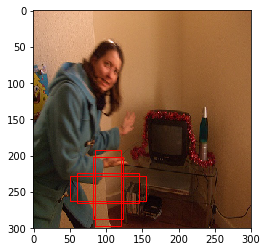

In [7]:
arg_to_class = get_arg_to_class(class_names)
image_prefix = '../datasets/VOCdevkit/VOC2007/JPEGImages/'
image_shape = model.input_shape[1:3]
box_visualizer = BoxVisualizer(image_prefix, image_shape, arg_to_class)
box_coordinates = prior_boxes[6080:6084, :]
box_visualizer.draw_normalized_box(box_coordinates)

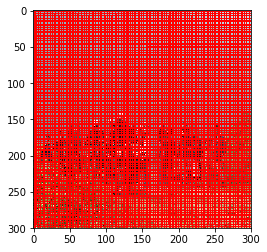

In [8]:
box_coordinates = prior_boxes[4400:6400, :]
box_visualizer.draw_normalized_box(box_coordinates)

## Ground truths

Data sample: 
 [[ 0.356       0.392       0.682       0.99466667  0.          0.          1.        ]
 [ 0.008       0.53866667  0.29        0.99733333  0.          0.          1.        ]
 [ 0.042       0.45333333  0.548       0.99466667  0.          1.          0.        ]]


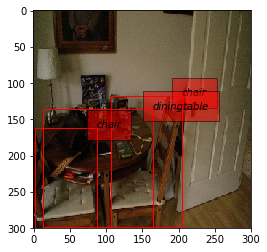

In [9]:
import random
data_key =  random.choice(list(ground_truth_data.keys()))
data_sample = ground_truth_data[data_key]
print('Data sample: \n', data_sample)
box_visualizer.draw_normalized_box(data_sample, data_key)

## Assigned prior boxes without regression

In [10]:
from utils.boxes import assign_prior_boxes

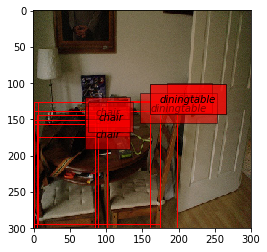

In [19]:
#prior_box_manager = PriorBoxManager(prior_boxes, num_classes=num_classes)
num_classes = len(class_names)
box_scale_factors = [.1, .1, .2, .2]
assigned_boxes = assign_prior_boxes(prior_boxes, data_sample,
                                              num_classes, box_scale_factors,
                                              regress=False,
                                              overlap_threshold=.8)
positive_mask = assigned_boxes[:, 4] != 1
positive_boxes = assigned_boxes[positive_mask]
box_visualizer.draw_normalized_box(positive_boxes, data_key)

## Assigned prior boxes with regression

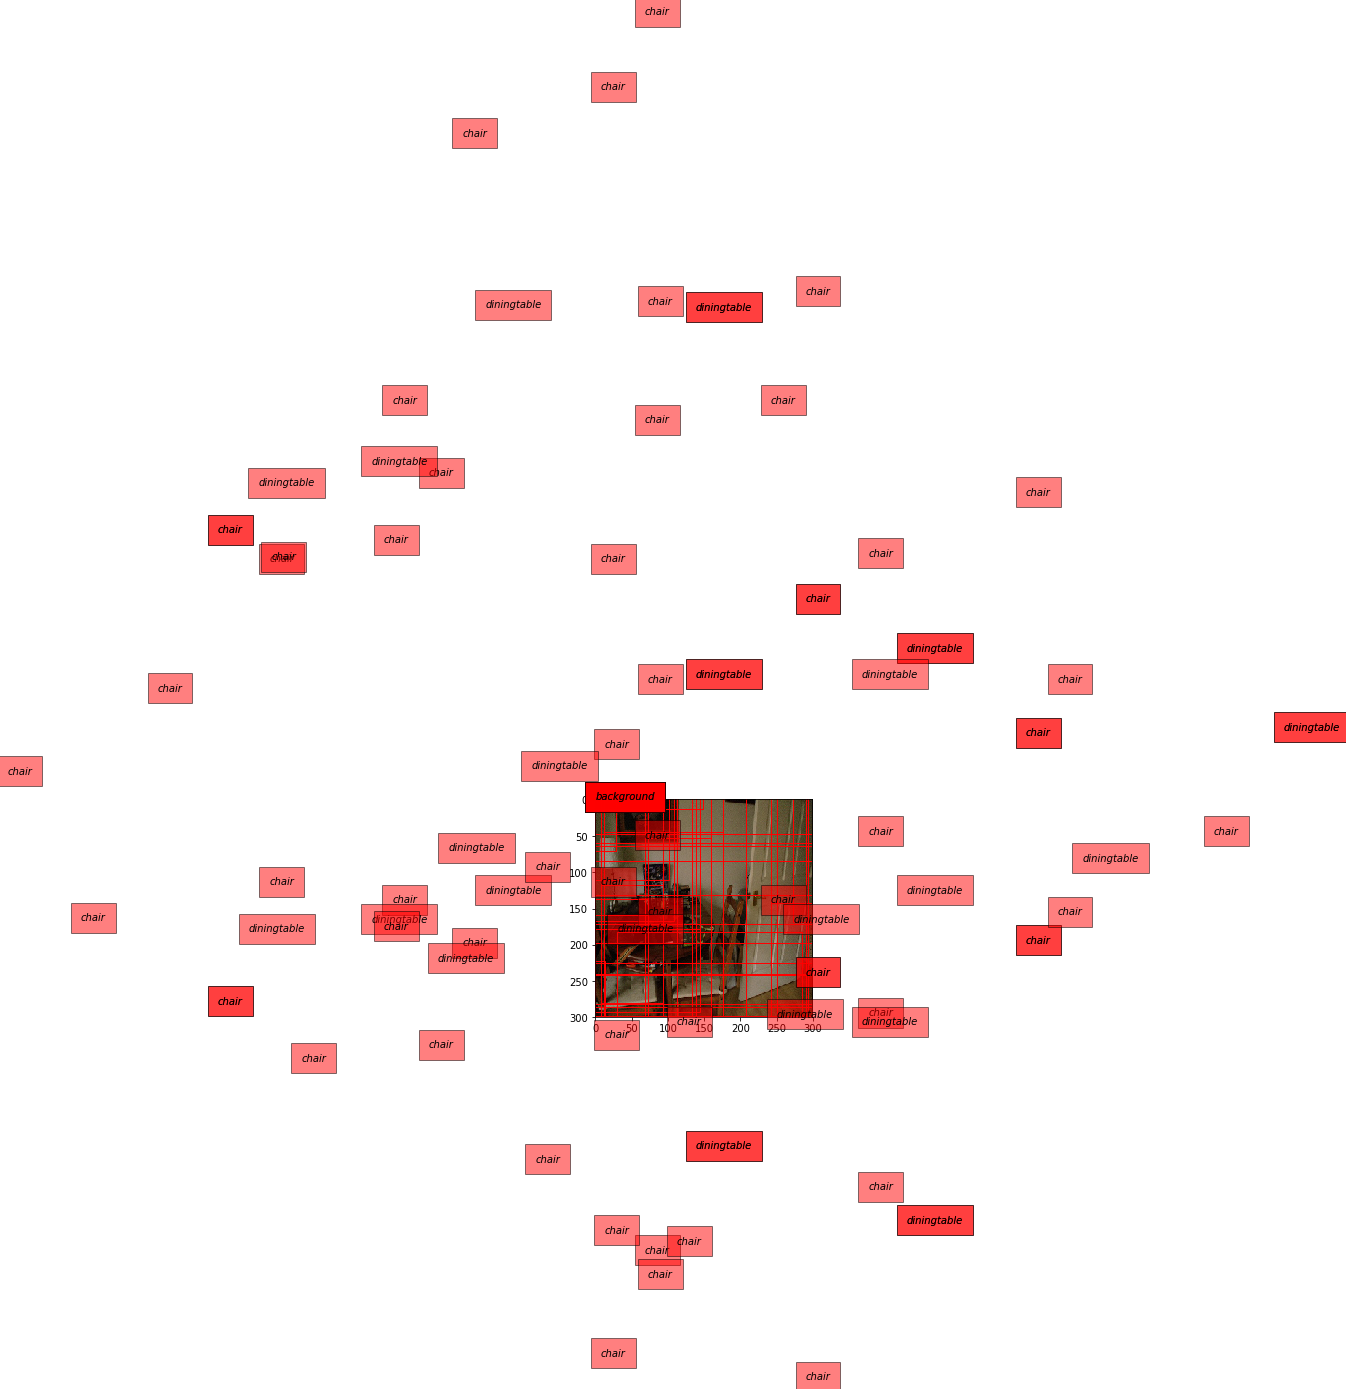

In [12]:
assigned_regressed_boxes = assign_prior_boxes(prior_boxes, data_sample,
                                              num_classes, box_scale_factors,
                                             regress=True)
positive_mask = assigned_regressed_boxes[:, 4] != 1
encoded_positive_boxes = assigned_regressed_boxes[positive_mask]
box_visualizer.draw_normalized_box(assigned_regressed_boxes, data_key)

## Assigned decoded boxes

In [13]:
from utils.boxes import decode_boxes

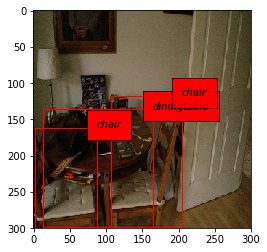

In [14]:
assigned_decoded_boxes = decode_boxes(assigned_regressed_boxes,
                                      prior_boxes, box_scale_factors)
decoded_positive_boxes = assigned_decoded_boxes[positive_mask]
box_visualizer.draw_normalized_box(decoded_positive_boxes, data_key)

## Data augmentation

In [15]:
from utils.data_augmentation import ImageGenerator
from utils.utils import load_image
from utils.utils import plot_images
from utils.utils import split_data
import numpy as np

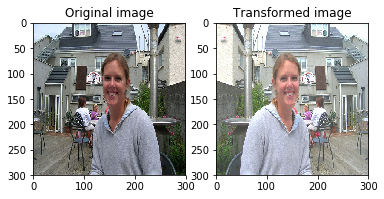

In [20]:
batch_size = 1
train_keys, validation_keys = split_data(ground_truth_data, training_ratio=.8)
image_generator = ImageGenerator(ground_truth_data,
                                 prior_boxes,
                                 num_classes,
                                 box_scale_factors,
                                 batch_size,
                                 image_shape,
                                 train_keys, validation_keys,
                                 image_prefix,
                                 vertical_flip_probability=0,
                                 horizontal_flip_probability=1)

generated_data = next(image_generator.flow(mode='demo'))
generated_input = generated_data[0]['input_1']
generated_output = generated_data[1]['predictions']
generated_image = np.squeeze(generated_input[0]).astype('uint8')
validation_image_name = image_prefix + validation_keys[0]
original_image = load_image(validation_image_name, False, image_shape)
plot_images(original_image, generated_image)

## Modified ground-truth

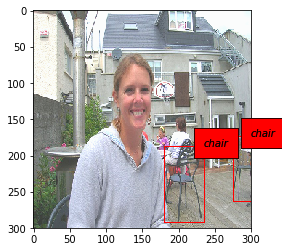

In [21]:
# finally draw the assigned boxes given by the generator
generated_encoded_boxes = np.squeeze(generated_output)
generated_boxes = decode_boxes(generated_encoded_boxes, prior_boxes,
                                                  box_scale_factors)
positive_mask = generated_boxes[:, 4] != 1
generated_positive_boxes = generated_boxes[positive_mask]
box_visualizer.draw_normalized_box(generated_positive_boxes, image_array=generated_image)